## Feature selection

Boruta is an advanced feature selection method that uses Random Forest as a base algorithm. Its goal is to identify all relevant features in a dataset, including those that might have a weaker impact on the model's predictive power but are still significant. It is particularly useful for datasets with many features where traditional methods of feature selection (such as mutual information or simple feature importance) might miss some important variables.


The main steps of the Boruta algorithm are:

Create Shadow Features:

For each feature in the dataset, create a shadow feature by randomly permuting (shuffling) the feature’s values. This step helps in understanding how important the real features are compared to random noise.
For example, if you have 10 original features, Boruta will create 10 shadow features.
Train Random Forest:

A Random Forest model is trained using the original features along with the shadow features. This model is used to rank the importance of each feature based on how it improves model performance.
Ranking Features:

The importance of each feature is determined by how much it contributes to reducing the impurity (e.g., Gini impurity) in the Random Forest. The higher the feature's contribution to impurity reduction, the more important the feature is considered.
Feature Comparison:

Each original feature is compared against its corresponding shadow feature’s importance. If the original feature has higher importance than its shadow feature, it is considered relevant.
Features are ranked based on their importance, and shadow features are always considered irrelevant.
Feature Elimination:

Boruta eliminates irrelevant features and keeps features that have higher importance than the shadow features. A feature is removed if its importance is significantly less than the highest shadow feature.
Iteration:

This process is repeated multiple times (usually several hundred iterations) to refine the ranking of features. The final set of selected features is determined based on consistent importance across the iterations.
Final Decision:

Once the algorithm has iterated enough, it returns a final list of features that are either:
Confirmed: Features that are significantly more important than their shadow counterparts.
Rejected: Features that are consistently less important than their shadow counterparts.
Tentative: Features that have mixed importance but may be relevant depending on the model.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [5]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_PL")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Label,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,30879,0,64.585900,0,27.0,0.377501,128.715226,0.422342,115.630163,15.181458,...,286.270009,0.289728,206.373786,44.577974,539.225137,3.320292,22924.739100,3.3445,2251,7338.2
1,31129,0,68.076660,2,20.0,0.657212,51.830551,0.557254,84.225204,8.530596,...,282.873623,0.310507,206.276556,39.697933,542.232602,2.864138,18182.687670,2.9605,2924,5438.6
2,30605,1,76.221760,1,28.0,0.520032,86.558742,0.594543,123.662642,13.400504,...,244.274039,0.370189,201.216707,46.081559,560.592790,3.415186,28045.350990,3.3145,4042,8434.4
3,30039,0,73.221085,0,30.0,0.396133,60.731686,0.596733,122.546512,15.571183,...,226.713342,0.517430,232.983710,30.461877,705.221498,2.937422,1196.160472,3.1505,3485,7476.2
4,30079,0,45.872690,0,30.0,0.404800,108.808540,0.520363,98.065558,13.483247,...,202.074647,0.354851,169.528802,50.680275,476.040561,3.017047,47743.254120,3.5420,3964,8021.8


In [6]:
# Split by subject
subjects = dataset['Label'].unique()
first_diag_per_subject = dataset.groupby('Label')['DIAGNOSIS'].first()

train_subs, test_subs = train_test_split(
    subjects,
    test_size=0.3,
    random_state=42,
    stratify=first_diag_per_subject
)

# Assign rows
train_df = dataset[dataset['Label'].isin(train_subs)].copy()
test_df  = dataset[dataset['Label'].isin(test_subs)].copy()

# Separate X and y
y_train = train_df['DIAGNOSIS']
y_test  = test_df['DIAGNOSIS']
X_train = train_df.drop(columns=['DIAGNOSIS'])
X_test  = test_df.drop(columns=['DIAGNOSIS'])

# -----------------------------
# Check for subject-level overlap
# -----------------------------
overlap_subjects = set(train_df['Label']).intersection(set(test_df['Label']))
if len(overlap_subjects) == 0:
    print("No subjects appear in both train and test sets.")
else:
    print(f"Overlapping subjects found: {overlap_subjects}")

print(f"Number of subjects in train: {len(train_df['Label'].unique())}")
print(f"Number of subjects in test: {len(test_df['Label'].unique())}")


No subjects appear in both train and test sets.
Number of subjects in train: 508
Number of subjects in test: 219


In [7]:
imputer_knn = IterativeImputer(
    estimator=ExtraTreesRegressor(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

In [8]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [9]:
from sklearn.preprocessing import StandardScaler

cols = [
    'Hip ASM', 'Hip Contrast', 'Hip Correlation', 'Hip Variance ', 'Hip Sum Average',
       'Hip Sum Variance', 'Hip Entropy', 'Hip Clusterhade', 'ERC ASM',
       'ERC CONTRAST', 'ERC CORRELATION', 'ERC VARIANCE ', 'ERC SUM AVERAGE',
       'ERC SUM VARIANCE', 'ERC ENTROPY', 'ERC CLUSTER SHADE',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'TOTAL_HIPPOCAMPUS_VOLUME'
]

scaler = StandardScaler()

# X_train_bayes_t
X_train_knn_t[cols] = scaler.fit_transform(X_train_knn_t[cols])

# X_test_bayes_t
X_test_knn_t[cols] = scaler.transform(X_test_knn_t[cols])

In [10]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [11]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [12]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((508, 23), (219, 23))

In [13]:
model = RandomForestClassifier(random_state=42,)

# let's initialize Boruta
sel = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
)

sel.fit(X_train_t.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	9
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	9
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	9
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	9
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Itera

BorutaPy(estimator=RandomForestClassifier(n_estimators=46,
                                          random_state=RandomState(MT19937) at 0x2BB85E37840),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2BB85E37840, verbose=2)

In [14]:
# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(sel.support_)):
    if sel.support_[i]:
        print("Passes the test: ", X_train_t.columns[i],
              " - Ranking: ", sel.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X_train_t.columns[i], " - Ranking: ", sel.ranking_[i])


------Support and Ranking for each feature------
Doesn't pass the test:  Label  - Ranking:  13
Doesn't pass the test:  Gender  - Ranking:  14
Passes the test:  Age  - Ranking:  1
Passes the test:  MMSE  - Ranking:  1
Doesn't pass the test:  Hip ASM  - Ranking:  2
Doesn't pass the test:  Hip Contrast  - Ranking:  7
Doesn't pass the test:  Hip Correlation  - Ranking:  4
Doesn't pass the test:  Hip Variance   - Ranking:  3
Doesn't pass the test:  Hip Sum Average  - Ranking:  2
Doesn't pass the test:  Hip Sum Variance  - Ranking:  6
Passes the test:  Hip Entropy  - Ranking:  1
Doesn't pass the test:  Hip Clusterhade  - Ranking:  12
Doesn't pass the test:  ERC ASM  - Ranking:  5
Passes the test:  ERC CONTRAST  - Ranking:  1
Passes the test:  ERC CORRELATION  - Ranking:  1
Doesn't pass the test:  ERC VARIANCE   - Ranking:  7
Doesn't pass the test:  ERC SUM AVERAGE  - Ranking:  9
Doesn't pass the test:  ERC SUM VARIANCE  - Ranking:  9
Doesn't pass the test:  ERC ENTROPY  - Ranking:  2
Doesn'

In [15]:
# Store selected feature names before transformation
selected_features = X_train_t.columns[sel.support_]
selected_features

Index(['Age', 'MMSE', 'Hip Entropy', 'ERC CONTRAST', 'ERC CORRELATION',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'TOTAL_HIPPOCAMPUS_VOLUME'],
      dtype='object')

<Axes: >

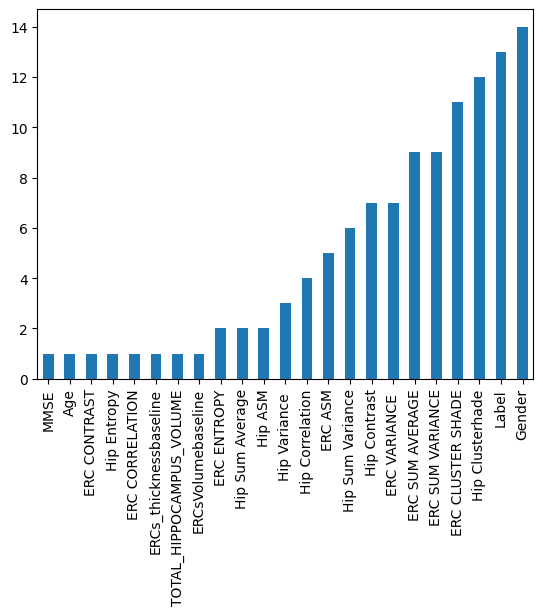

In [16]:
ranking = sel.ranking_
plot_ranking = pd.Series(ranking)
plot_ranking.index = X_train.columns
plot_ranking.sort_values().plot(kind="bar")

In [17]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((508, 8), (219, 8))

## Classification Test

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def run_model(classifier_name, X_train, y_train):
        
        columns = len(X_train.columns)
        
        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False)
                
        elif classifier_name == "Logistic Regression":
                model = LogisticRegression(
                class_weight="balanced",
                solver="lbfgs",
                max_iter=500,
                random_state=42
                )
        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "ANOVA",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [19]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_knn_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_knn_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_knn_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

trained_lg_n, metrics_lg_n = run_model("Logistic Regression", X_train_knn_t, y_train)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", X_train_t, y_train)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

In [20]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t, metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Metric", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Feature Selection Classifier          Metric            Fit Time Total Features               
ANOVA             Random Forest       balanced_accuracy 0.605    23                   0.930   
                                                        0.313    8                    0.914   
                  XGBoost             balanced_accuracy 0.483    23                   1.000   
                                                        0.259    8                    1.000   
                  NGBoost             balanced_accuracy 1.377    23                   0.626   
                                                        0.746    8                    0.593   
                  Logistic Regression balanced_accuracy 0.135    23                   0.665   
                                                        0.129    8                    0.672   

                                                                                 Std Train  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 0.605    23                  0.011   
                                                        0.313    8                   0.009   
                  XGBoost             balanced_accuracy 0.483    23                  0.000   
                                                        0.259    8                   0.000   
                  NGBoost             balanced_accuracy 1.377    23                  0.015   
                                                        0.746    8                   0.020   
                  Logistic Regression balanced_accuracy 0.135    23                  0.017   
                                                        0.129    8                   0.021   

                                                                                 Mean Test  \
Feature Selection Classifier          Metric            Fit Time Total Features              
ANOVA             Random Forest       balanced_accuracy 0.605    23                  0.570   
                                                        0.313    8                   0.542   
                  XGBoost             balanced_accuracy 0.483    23                  0.559   
                                                        0.259    8                   0.543   
                  NGBoost             balanced_accuracy 1.377    23                  0.530   
                                                        0.746    8                   0.526   
                  Logistic Regression balanced_accuracy 0.135    23                  0.572   
                                                        0.129    8                   0.618   

                                                                                 Std Test  
Feature Selection Classifier          Metric            Fit Time Total Features            
ANOVA             Random Forest       balanced_accuracy 0.605    23                 0.051  
                                                        0.313    8                  0.050  
                  XGBoost             balanced_accuracy 0.483    23                 0.078  
                                                        0.259    8                  0.047  
                  NGBoost             balanced_accuracy 1.377    23                 0.047  
                                                        0.746    8                  0.045  
                  Logistic Regression balanced_accuracy 0.135    23                 0.119  
                                                        0.129    8                  0.094

In [21]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [22]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [23]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        columns = len(X_train.columns)

        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=100,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [24]:
results = "all"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    pred_lg_n = eval_model("Logistic Regression", trained_lg_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t, pred_lg_n, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)

    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier          Classification Time Total Features Metric                          
Boruta            Random Forest       0.112               23             accuracy                0.947   
                                                                         balanced_accuracy       0.924   
                                                                         precision_macro         0.936   
                                                                         recall_macro            0.924   
                                                                         f1_macro                0.930   
                                                                         roc_auc_macro           0.988   
                                                                         specificity_macro       0.956   
                                      0.083               8              accuracy                0.917   
                                                                         balanced_accuracy       0.898   
                                                                         precision_macro         0.853   
                                                                         recall_macro            0.898   
                                                                         f1_macro                0.873   
                                                                         roc_auc_macro           0.983   
                                                                         specificity_macro       0.943   
                  XGBoost             0.177               23             accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision_macro         1.000   
                                                                         recall_macro            1.000   
                                                                         f1_macro                1.000   
                                                                         roc_auc_macro           1.000   
                                                                         specificity_macro       1.000   
                                      0.101               8              accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision_macro         1.000   
                                                                         recall_macro            1.000   
                                                                         f1_macro                1.000   
                                                                         roc_auc_macro           1.000   
                                                                         specificity_macro       1.000   
                  NGBoost             0.920               23             accuracy                0.866   
                                                                         balanced_accuracy       0.609   
                                                                         precision_macro         0.926   
                                                                         recall_macro            0.609   
                                                                         f1_macro                0.660   
                                                                         roc_auc_macro           0.983   
                                                                         specificity_macro       0.853   
                                      1.265               8              accuracy                0.858   
                                                                

In [25]:
# Quick NGBoost check
lr_auc = prediction_df_report.xs(
    ("Boruta", "Logistic Regression", "roc_auc_macro"),
    level=("Feature Selection", "Classifier", "Metric")
)["Test data"]
print("NGBoost (Boruta) macro AUC:", lr_auc)

NGBoost (Boruta) macro AUC: Classification Time  Total Features
0.075                23                0.817
0.110                8                 0.825
Name: Test data, dtype: float64


In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_multi(models_dict, X_tests_dict, y_test, show_per_class=False):
    classes = sorted(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=classes)
    
    plt.figure(figsize=(10, 7))
    
    for clf_name, imputer_models in models_dict.items():
        for imp_name, model in imputer_models.items():
            X_test = X_tests_dict[imp_name]
            y_proba = model.predict_proba(X_test)
            
            # Per-class ROC
            fpr = dict()
            tpr = dict()
            aucs = []
            for i in range(len(classes)):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                aucs.append(auc(fpr[i], tpr[i]))
                
                if show_per_class:
                    plt.plot(fpr[i], tpr[i], linestyle='--', alpha=0.3,
                             label=f'{clf_name} - {imp_name} - Class {classes[i]}')
            
            # Macro AUC using sklearn
            auc_macro = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
            
            # Smooth macro TPR for plotting
            fpr_macro = np.linspace(0, 1, 100)
            tpr_macro = np.mean([np.interp(fpr_macro, fpr[i], tpr[i]) for i in range(len(classes))], axis=0)
            
            plt.plot(fpr_macro, tpr_macro, linewidth=2,
                     label=f'{clf_name} ({imp_name}) AUC={auc_macro:.3f}')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves Using Boruta (OASIS-3)")
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.show()


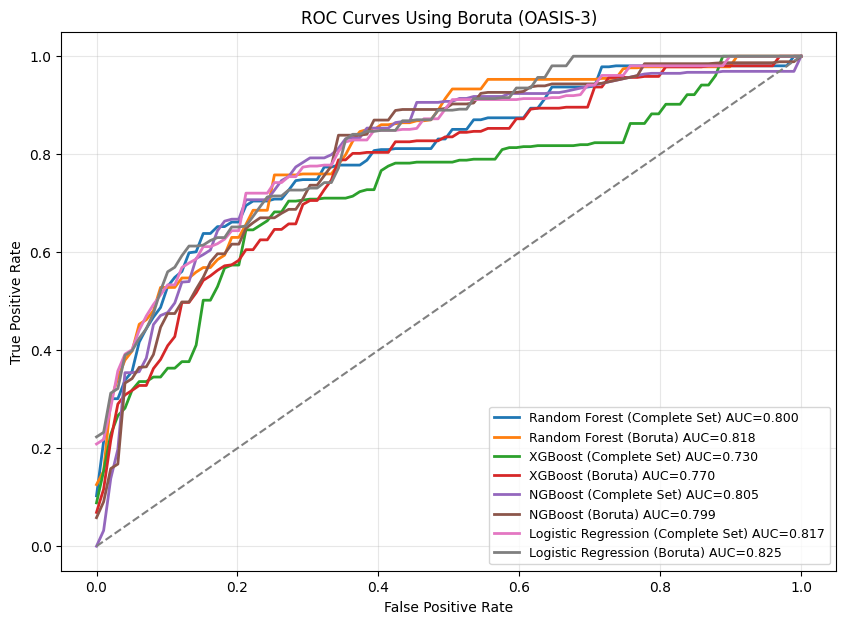

In [32]:
# ROC AUC plotting for ALL models
models_dict = {
    "Random Forest": {"Complete Set": trained_rf_n, "Boruta": trained_rf_t},
    "XGBoost": {"Complete Set": trained_xgb_n, "Boruta": trained_xgb_t},
    "NGBoost": {"Complete Set": trained_ngb_n, "Boruta": trained_ngb_t},
    "Logistic Regression": {"Complete Set": trained_lg_n, "Boruta": trained_lg_t}
}

X_tests_dict = {
    "Complete Set": X_test_knn_t,
    "Boruta": X_test_t
}

plot_roc_multi(models_dict, X_tests_dict, y_test, show_per_class=False)